In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

In [2]:
data1 = pd.read_csv("/kaggle/input/spam-mails-dataset/spam_ham_dataset.csv")
data2 = pd.read_csv("/kaggle/input/email-spam-dataset/completeSpamAssassin.csv")
data1 = data1[['Unnamed: 0', 'text', 'label_num']].rename(columns={'text' : 'Body', 'label_num' : 'Label'})
data1.head()


,Unnamed: 0,Body,Label
0,605,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,"Subject: photoshop , windows , office . cheap ...",1
4,2030,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
data = pd.concat([data1, data2])
mapping = {0 : 'ham', 1 : 'spam'}
data['Category'] = data['Label'].map(mapping)
data.head()

,Unnamed: 0,Body,Label,Category
0,605,Subject: enron methanol ; meter # : 988291\r\n...,0,ham
1,2349,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,ham
2,3624,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,ham
3,4685,"Subject: photoshop , windows , office . cheap ...",1,spam
4,2030,Subject: re : indian springs\r\nthis deal is t...,0,ham


## Distribution of mails

In [4]:
temp = data.groupby('Label', as_index=False).agg({'Category' : 'count'})
temp = temp.assign(New_label = pd.DataFrame(['ham', 'spam']))[['Category', 'New_label']]
temp.rename(columns = {'Category' : 'Count', 'New_label' : 'Category'}, inplace = True)
temp

,Count,Category
0,7822,ham
1,3395,spam


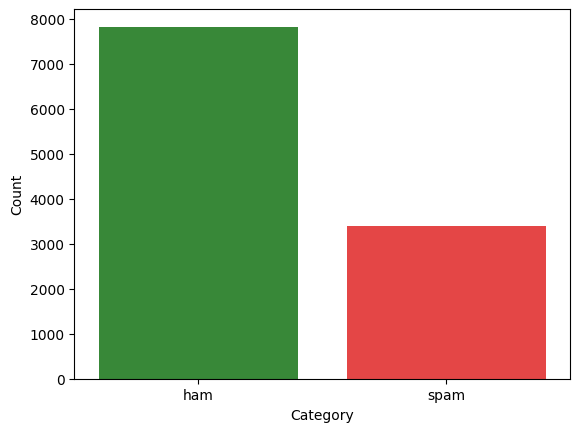

In [5]:

sns.barplot(data=temp, x = 'Category', y = 'Count', alpha = 0.83, palette = ['green', 'red'])

plt.show()

## Feature Processing

In [6]:
df = data.loc[:, ['Body', 'Label']]
df = df.dropna(subset = ['Body'])
df.head()

,Body,Label
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
df['Body'].isna().sum()

0

In [8]:
def process_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in stop_words and word.isalpha() ]
    return " ".join(words)
#process_lemmatize("Alen loves love lovely armrestling, and math.")
df['Body'] = df['Body'].apply(process_lemmatize)
df.head()


,Body,Label
0,subject enron methanol meter follow note gave ...,0
1,subject hpl nom january see attached file hpln...,0
2,subject neon retreat ho ho ho around wonderful...,0
3,subject photoshop window office cheap main tre...,1
4,subject indian spring deal book teco pvr reven...,0


### Train and Plot functions

In [89]:
knn, lr, cb = None, None, None
def train():
    global knn, lr, cb
    knn, lr, cb = KNN(), LogisticRegression(max_iter = 1000), CatBoostClassifier(iterations = 100, verbose = False)
    knn.fit(X_train, y_train)
    lr.fit(X_train, y_train)
    cb.fit(X_train, y_train)
    return knn, lr, cb

def print_roc_auc():
    global knn, lr, cb
    fpr1, tpr1, _ = roc_curve(y_test, knn.predict(X_test.values))
    auc1 = auc(fpr1, tpr1)

    # Calculate ROC curves and AUC scores for each model
    fpr2, tpr2, _ = roc_curve(y_test, lr.predict(X_test.values))
    auc2= auc(fpr2, tpr2)

    fpr3, tpr3, _ = roc_curve(y_test, cb.predict(X_test.values))
    auc3 = auc(fpr3, tpr3)

    # Plot ROC curves for all three models on the same plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'KNN (AUC = {auc1:.2f})')
    plt.plot(fpr2, tpr2, color='green', lw=2, label=f'Log Reg (AUC = {auc2:.2f})')
    plt.plot(fpr3, tpr3, color='blue', lw=2, label=f'CatBoost (AUC = {auc3:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
def print_pr_auc():
    global knn, lr, cb
    y_scores_knn = knn.predict_proba(X_test)[:, 1]
    y_scores_lr = lr.predict_proba(X_test)[:, 1]
    y_scores_cb = cb.predict_proba(X_test)[:, 1]

    precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_scores_knn)
    pr_auc_knn = average_precision_score(y_test, y_scores_knn)

    precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_scores_lr)
    pr_auc_lr = average_precision_score(y_test, y_scores_lr)

    precision_cb, recall_cb, _ = precision_recall_curve(y_test, y_scores_cb)
    pr_auc_cb = average_precision_score(y_test, y_scores_cb)

    # Plot PR curves for all three models
    plt.figure(figsize=(8, 6))
    plt.plot(recall_knn, precision_knn, color='darkorange', lw=2, label=f'KNN (AUC-PR = {pr_auc_knn:.2f})')
    plt.plot(recall_lr, precision_lr, color='green', lw=2, label=f'Logistic Regression (AUC-PR = {pr_auc_lr:.2f})')
    plt.plot(recall_cb, precision_cb, color='blue', lw=2, label=f'CatBoost (AUC-PR = {pr_auc_cb:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

## Bag Of Words 

In [103]:
cv = CountVectorizer(max_features = 1500)
bag = (cv.fit_transform(df['Body'])).toarray()
names = cv.get_feature_names_out()
X = pd.DataFrame(data= bag, columns = names)
y = df['Label']
X.head()

,ability,able,about,absolutely,accept,access,according,account,accounting,across,...,year,yes,yesterday,yet,york,you,young,your,zero,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Fitting models

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
train()

(KNeighborsClassifier(),
 LogisticRegression(max_iter=1000),
 <catboost.core.CatBoostClassifier at 0x7db51999efb0>)

### ROC_AUC

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


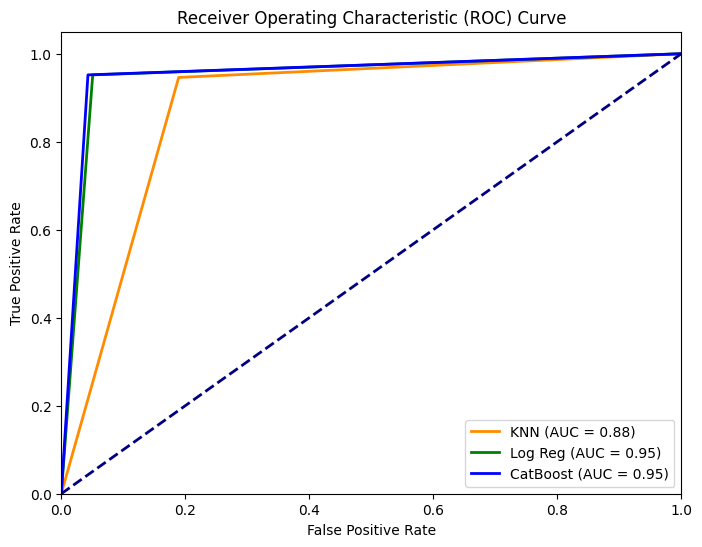

In [12]:
print_roc_auc()

### PR-AUC

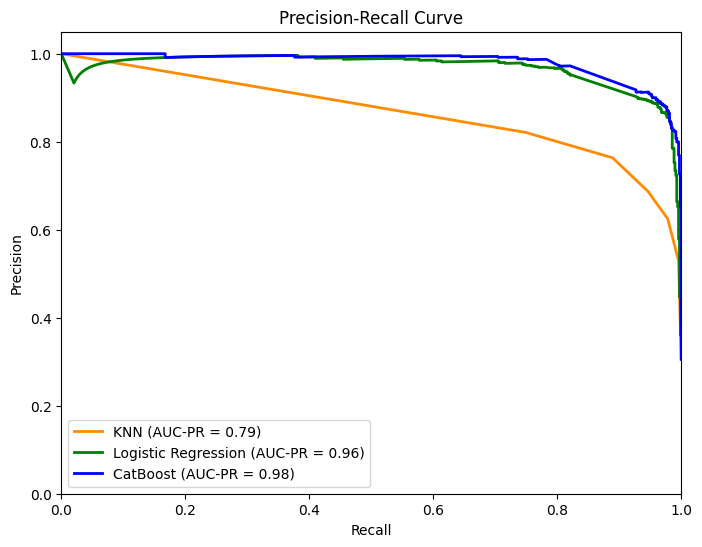

In [13]:
print_pr_auc()

## TF-IDF

In [105]:
tf_idf = TfidfVectorizer()
matrix =  tf_idf.fit_transform(df['Body']).toarray()
names = tf_idf.get_feature_names_out()
X = pd.DataFrame(data = matrix, columns = names)
y = df['Label']
X.head()

,aa,aaa,aaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaanyway,aaar,aabda,aabvmmq,aac,aachecar,...,ìœ,ìš,ìšµë,ìž,ìžˆëš,íœ,œé,œì,œí,šåª
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Fitting models

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
train()

(KNeighborsClassifier(),
 LogisticRegression(max_iter=1000),
 <catboost.core.CatBoostClassifier at 0x7db512660880>)

### ROC_AUC

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


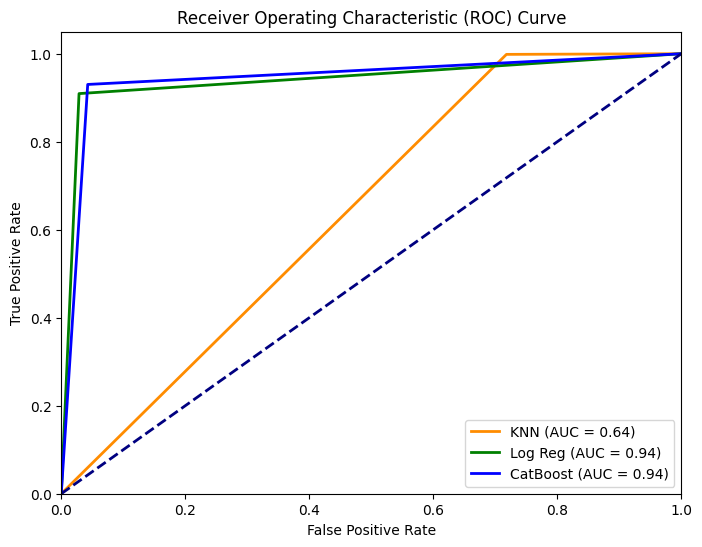

In [16]:
print_roc_auc()

### PR-AUC

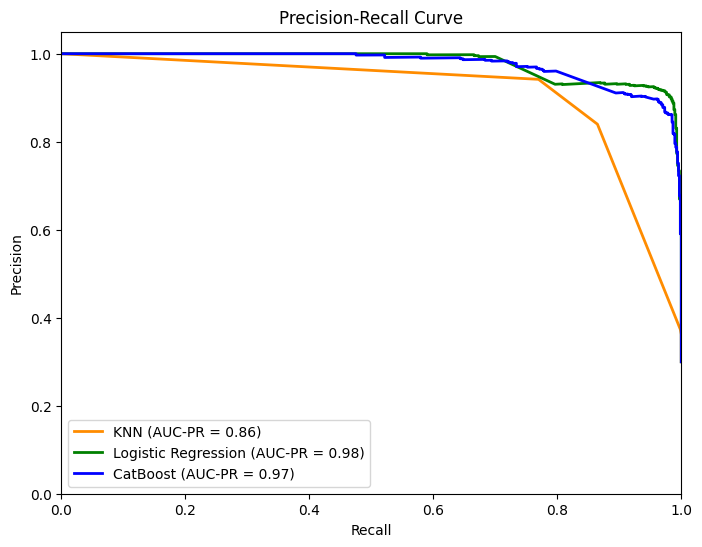

In [17]:
print_pr_auc()

## Word2Vec

In [101]:
X = df['Body']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
from gensim.models import Word2Vec


In [102]:
sentences = []
for sent in X_train.tolist():
    sentences.append(sent.split())
len(sentences)

8972

In [103]:
w2v_model = Word2Vec(vector_size=100, window=5, min_count=1, sg=0)
w2v_model.build_vocab(sentences, progress_per = 1000)

In [104]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(32180343, 33373890)

In [105]:
def get_word_embedding(word):
    try:
        embedding = w2v_model.wv[word]
    except KeyError:
        embedding = np.zeros(100)
    return embedding

In [106]:
def sentence_embedding(sent):
    vectors = [get_word_embedding(word) for word in sent]
    return np.mean(vectors, axis = 0)

In [107]:
d = df.loc[:]
d['Body'] = df['Body'].apply(sentence_embedding)
d.dropna(subset = ['Body'], inplace = True)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [108]:
d['Body'].isna().sum()

0

In [109]:
X = [item.flatten() for item in d['Body']]
X = np.vstack(X)  # Stack flattened arrays vertically
y = d['Label']


In [116]:
knn, lr, cb = None, None, None
def train():
    global knn, lr, cb
    knn, lr, cb = KNN(), LogisticRegression(max_iter = 1000), CatBoostClassifier(iterations = 100, verbose = False)
    knn.fit(X_train, y_train)
    lr.fit(X_train, y_train)
    cb.fit(X_train, y_train)
    return knn, lr, cb

def print_roc_auc():
    global knn, lr, cb
    fpr1, tpr1, _ = roc_curve(y_test, knn.predict(X_test))
    auc1 = auc(fpr1, tpr1)

    # Calculate ROC curves and AUC scores for each model
    fpr2, tpr2, _ = roc_curve(y_test, lr.predict(X_test))
    auc2= auc(fpr2, tpr2)

    fpr3, tpr3, _ = roc_curve(y_test, cb.predict(X_test))
    auc3 = auc(fpr3, tpr3)

    # Plot ROC curves for all three models on the same plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'KNN (AUC = {auc1:.2f})')
    plt.plot(fpr2, tpr2, color='green', lw=2, label=f'Log Reg (AUC = {auc2:.2f})')
    plt.plot(fpr3, tpr3, color='blue', lw=2, label=f'CatBoost (AUC = {auc3:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
def print_pr_auc():
    global knn, lr, cb
    y_scores_knn = knn.predict_proba(X_test)[:, 1]
    y_scores_lr = lr.predict_proba(X_test)[:, 1]
    y_scores_cb = cb.predict_proba(X_test)[:, 1]

    precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_scores_knn)
    pr_auc_knn = average_precision_score(y_test, y_scores_knn)

    precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_scores_lr)
    pr_auc_lr = average_precision_score(y_test, y_scores_lr)

    precision_cb, recall_cb, _ = precision_recall_curve(y_test, y_scores_cb)
    pr_auc_cb = average_precision_score(y_test, y_scores_cb)

    # Plot PR curves for all three models
    plt.figure(figsize=(8, 6))
    plt.plot(recall_knn, precision_knn, color='darkorange', lw=2, label=f'KNN (AUC-PR = {pr_auc_knn:.2f})')
    plt.plot(recall_lr, precision_lr, color='green', lw=2, label=f'Logistic Regression (AUC-PR = {pr_auc_lr:.2f})')
    plt.plot(recall_cb, precision_cb, color='blue', lw=2, label=f'CatBoost (AUC-PR = {pr_auc_cb:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
train()

(KNeighborsClassifier(),
 LogisticRegression(max_iter=1000),
 <catboost.core.CatBoostClassifier at 0x79563b2f9d50>)

### ROC_AUC

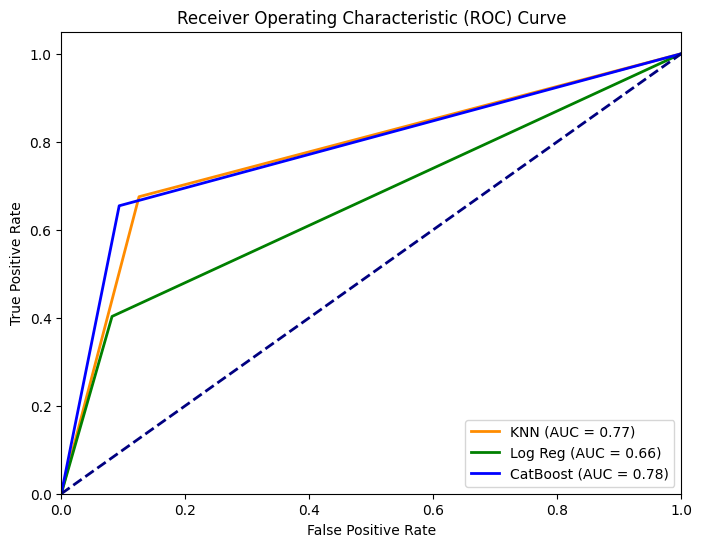

In [118]:
print_roc_auc()

### PR_AUC

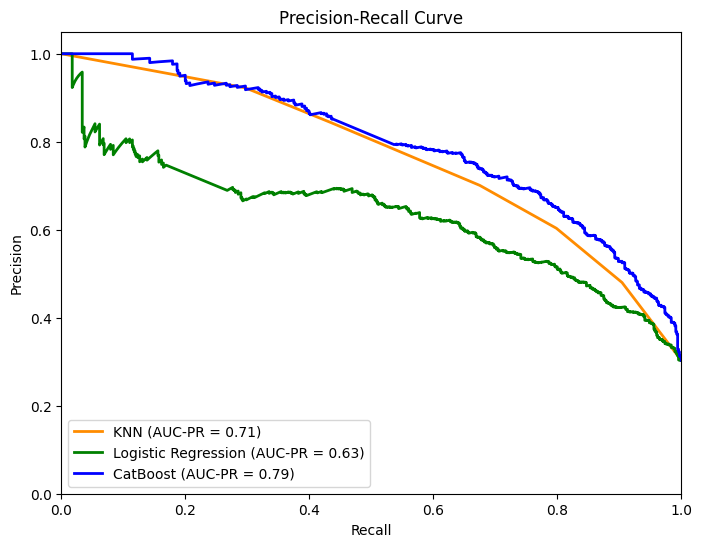

In [119]:
print_pr_auc()